# I. Выгрузка необходимых библиотек

In [1]:
import torch
from torch import nn
import torch.utils.data as data
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import warnings

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

cuda


# II. Подготовка данных
## Загрузка данных

Данные представляют собой изображения. Кроме того, даны две таблицы: train и test. Таблица train содержит название изображения (id) и класс (target - 1, если изображение сгенерировано, 0 - если нет). Таблица test содержит только названия изображений. Для начала я загружу данные.

In [3]:
train = pd.read_csv('data_csv/train.csv')
test = pd.read_csv('data_csv/test.csv')

In [4]:
train.shape

(1012, 2)

In [5]:
test.shape

(506, 1)

In [6]:
train.head(10)

,id,target
0,gL5fWrgNPU.jpg,0
1,KKWXJDN8uM.png,1
2,Wb2I0CXlAY.jpg,0
3,G7PLhKpaf7.jpeg,1
4,DEUkeefz6Z.jpg,0
5,enth8MGCce.jpg,0
6,hG9nlBfDeh,1
7,Re69C5wIs7.jpg,0
8,fsCx46u0Bq.jpg,0
9,yEi4q3wAJS.jpg,0


В таблице выше видно, что одно из названий изображений не имеет формата. Перед тем как загружать изображения, я хотела бы проверить, есть ли еще изображения с неверным форматом.

In [7]:
# необходимые функции для проверки формата изображения

def check_jpg_format(img_name):
    return img_name.lower().endswith('.jpg')


def check_png_format(img_name):
    return img_name.lower().endswith('.png')


def check_jpeg_format(img_name):
    return img_name.lower().endswith('.jpeg')


def check_webp_format(img_name):
    return img_name.lower().endswith('.webp')

In [8]:
# проверка формата изображений

all_train_images = train.id.values.tolist()
all_targets = train.target.values.tolist()
count_jpg = 0
count_png = 0
count_jpeg = 0
no_format = 0
no_format_files = []

for img in all_train_images:
    if check_jpg_format(img):
        count_jpg += 1
    elif check_png_format(img):
        count_png += 1
    elif check_jpeg_format(img):
        count_jpeg += 1
    else:
        no_format += 1
        no_format_files.append(img)

print(f'jpg: {count_jpg}, png: {count_png}, jpeg: {count_jpeg}')
print(f'no format: {no_format}')

jpg: 667, png: 8, jpeg: 171
no format: 166


Как оказалось, датасет содержит изображения, которые не имеют формат. Укажу форматы для таких изображений. 

In [9]:
def get_file_format(file_name):
    arr = os.listdir('images')

    for a in arr:
        if file_name in a:
            if check_jpg_format(a):
                return 'jpg'
            elif check_png_format(a):
                return 'png'
            elif check_jpeg_format(a):
                return 'jpeg'
            elif check_webp_format(a):
                return 'webp'


count_png = 0
count_jpeg = 0
count_jpg = 0
for i in no_format_files:
    if get_file_format(i) == 'jpg':
        count_jpg += 1
    elif get_file_format(i) == 'png':
        count_png += 1
    elif get_file_format(i) == 'jpeg':
        count_jpeg += 1

print('Действительные форматы изображений')
print(f'jpg: {count_jpg}, png: {count_png}, jpeg: {count_jpeg}')

Действительные форматы изображений
jpg: 0, png: 166, jpeg: 0


In [10]:
for i in range(len(all_train_images)):
    if all_train_images[i] in no_format_files:
        all_train_images[i] = all_train_images[i] + '.png'

train = pd.DataFrame({'id': all_train_images, 'target': all_targets})

Есть предположение, что тестовый датасет имеет такие же проблемы. Заранее проверю это и справлюсь с проблемой, если она есть.

In [11]:
all_test_images = test.id.values.tolist()
count_jpg = 0
count_png = 0
count_jpeg = 0
count_webp = 0
no_format = 0
no_format_files = []

for img in all_test_images:
    if check_jpg_format(img):
        count_jpg += 1
    elif check_png_format(img):
        count_png += 1
    elif check_jpeg_format(img):
        count_jpeg += 1
    elif check_webp_format(img):
        count_webp += 1
    else:
        no_format += 1
        no_format_files.append(img)

print(f'jpg: {count_jpg}, png: {count_png}, jpeg: {count_jpeg}, webp: {count_webp}')
print(f'no format: {no_format}')

jpg: 0, png: 1, jpeg: 420, webp: 2
no format: 83


In [12]:
count_png = 0
count_jpeg = 0
count_jpg = 0
count_webp = 0
for i in no_format_files:
    if get_file_format(i) == 'jpg':
        count_jpg += 1
    elif get_file_format(i) == 'png':
        count_png += 1
    elif get_file_format(i) == 'jpeg':
        count_jpeg += 1
    elif get_file_format(i) == 'webp':
        count_webp += 1

print('Действительные форматы изображений')
print(f'jpg: {count_jpg}, png: {count_png}, jpeg: {count_jpeg}, webp: {count_webp}')

Действительные форматы изображений
jpg: 0, png: 83, jpeg: 0, webp: 0


In [13]:
for i in range(len(all_test_images)):
    if all_test_images[i] in no_format_files:
        all_test_images[i] = all_test_images[i] + '.png'

test = pd.DataFrame({'id': all_test_images})

## Аугментация изображений и подготовка датасета

In [14]:
transformer = {
    'original': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'augmented_1': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'augmented_2': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}

In [15]:
class TrainDataset(data.Dataset):
    def __init__(self, d, transform=None):
        self.data = d
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        img_get = Image.open(f'./images/{img_name}').convert('RGB')
        label = self.data.iloc[idx, 1]

        if self.transform:
            img_get = self.transform(img_get)

        return img_get, label

In [16]:
BATCH_SIZE = 32

original = TrainDataset(train, transform=transformer['original'])

train_val, test_data = train_test_split(original, test_size=0.2, random_state=42, stratify=train.target.values)

train_val = torch.utils.data.ConcatDataset([
    train_val,
    TrainDataset(train, transform=transformer['augmented_1']),
    TrainDataset(train, transform=transformer['augmented_2']),

])

train, val = train_test_split(train_val, test_size=0.2, random_state=42, stratify=[i[1] for i in train_val])

loaders = {
    'train': data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4),
    'val': data.DataLoader(val, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4),
    'test': data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4)
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


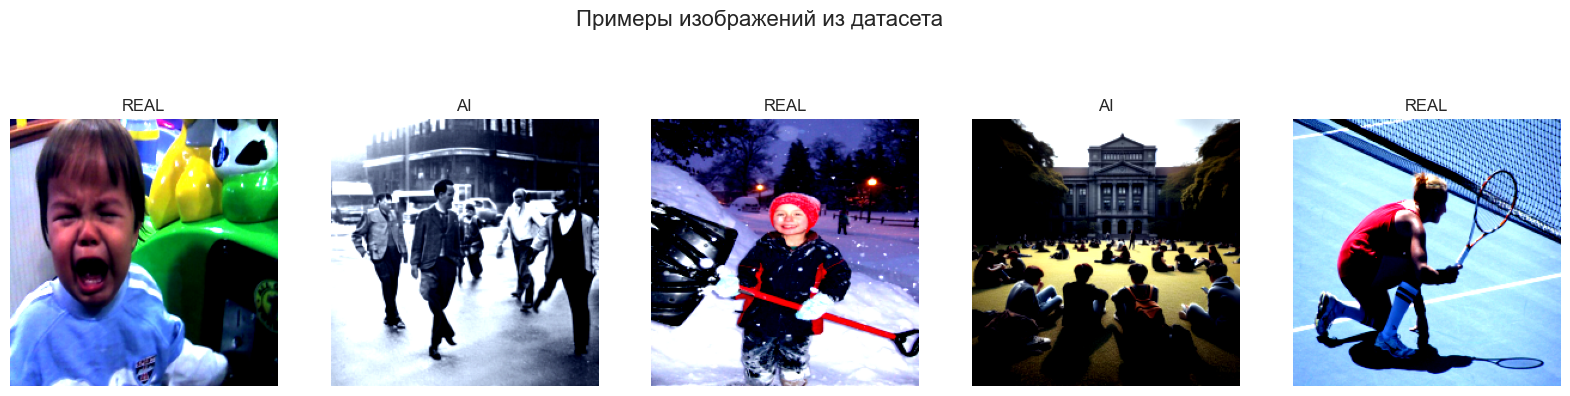

In [17]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

plt.suptitle('Примеры изображений из датасета', fontsize=16)

for i in range(5):
    ax[i].imshow(original[i][0].permute(1, 2, 0) * 0.5 + 0.5)
    ax[i].set_title('AI' if original[i][1] == 1 else 'REAL')
    ax[i].axis('off')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


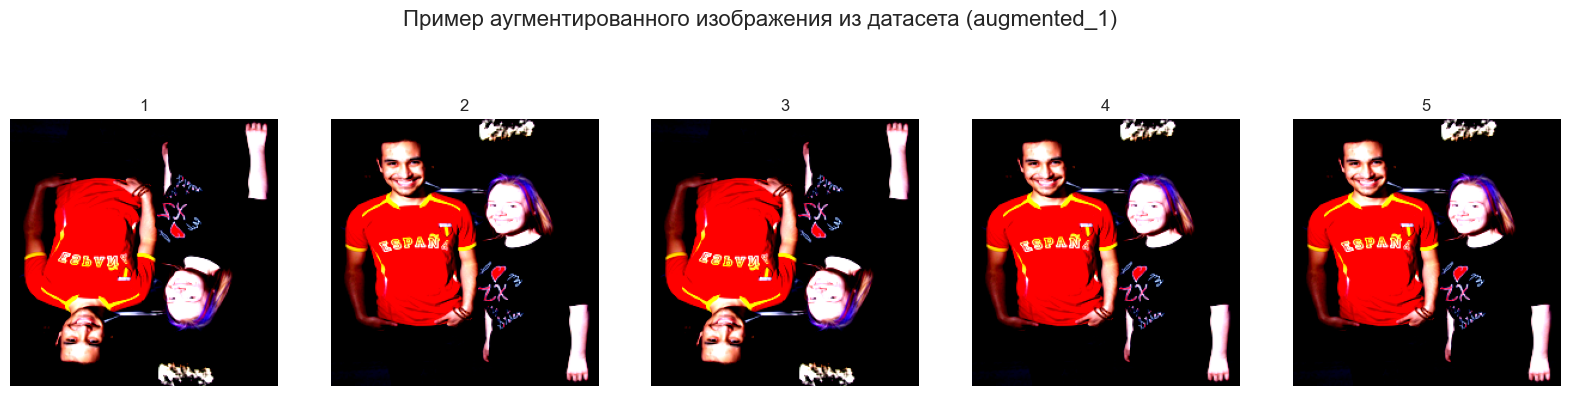

In [18]:
image_path = './images/0a1KuiILS4.jpg'

fig, ax = plt.subplots(1, 5, figsize=(20, 5))

plt.suptitle('Пример аугментированного изображения из датасета (augmented_1)', fontsize=16)
image = Image.open(image_path).convert('RGB')

for i in range(5):
    ax[i].imshow(transformer['augmented_1'](image).permute(1, 2, 0) * 0.5 + 0.5)
    ax[i].set_title(i + 1)
    ax[i].axis('off')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


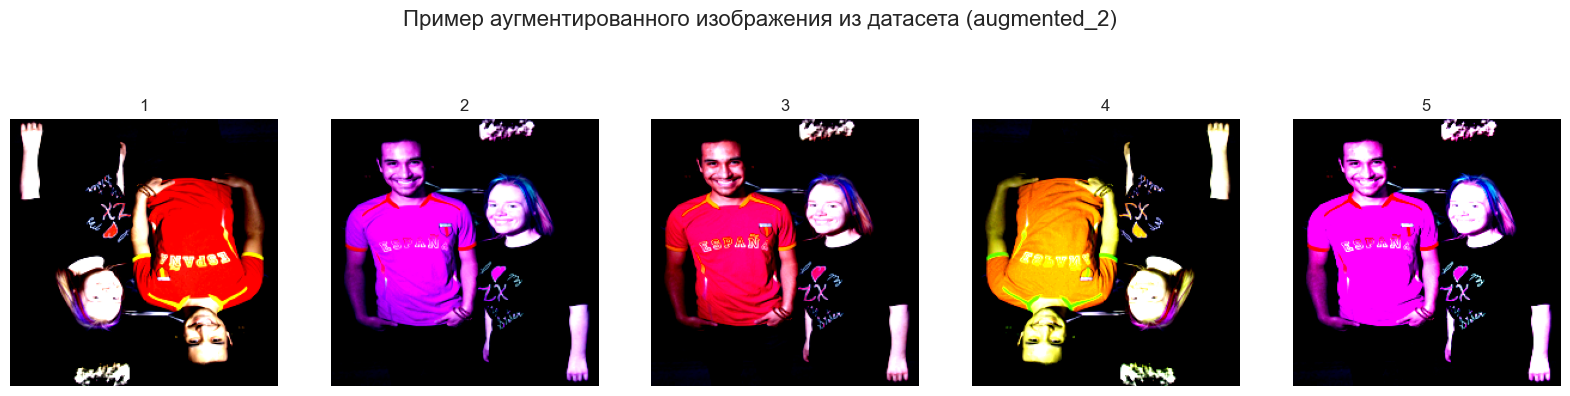

In [19]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

plt.suptitle('Пример аугментированного изображения из датасета (augmented_2)', fontsize=16)
image = Image.open(image_path).convert('RGB')

for i in range(5):
    ax[i].imshow(transformer['augmented_2'](image).permute(1, 2, 0) * 0.5 + 0.5)
    ax[i].set_title(i + 1)
    ax[i].axis('off')

plt.show()

# III. Обучение модели

In [20]:
train_loss = []
val_loss = []
accuracy = []


def train(model, optimizer, loss_fn, train_loader, val_loader, epoch=20, device='cpu'):
    for epoch in range(epoch):
        start_time = time.time()
        training_loss = 0.0
        valid_loss = 0.0

        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, target = batch
            inputs = inputs.to(device)
            target = target.to(device)
            output = model(inputs)
            loss_val = loss_fn(output, target)
            loss_val.backward()
            optimizer.step()
            training_loss += loss_val.data.item()
        training_loss /= len(train_loader.dataset)
        train_loss.append(training_loss)

        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss_val = loss_fn(output, targets)
            valid_loss += loss_val.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]

        valid_loss /= len(val_loader.dataset)
        val_loss.append(valid_loss)

        end_time = time.time()
        epoch_time = end_time - start_time

        accuracy.append(num_correct / num_examples)
        print(
            'Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}, time = {:.2f} sec.'.format(
                epoch + 1, training_loss,
                valid_loss,
                num_correct / num_examples, epoch_time))


In [21]:
def evaluation(model, loader):
    model.eval()
    all_preds = []
    all_targets = []

    for batch in loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        output = model(inputs)
        targets = targets.to(device)
        preds = torch.max(F.softmax(output), dim=1)[1]
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

    return all_preds, all_targets

In [22]:
def test_pred(img, model):
    check = Image.open(f'./images/{img}').convert('RGB')

    check = transformer['original'](check).to(device)
    check = check.unsqueeze(0)

    with torch.no_grad():
        model.eval()
        output = model(check)
        # для более понятного результата я буду округлять вероятность до трёх знаков после запятой
        return round(F.softmax(output)[0][1].item(), 3)


In [23]:
vit_16 = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1)

vit_16

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [24]:
for param in vit_16.parameters():
    param.requires_grad = False

vit_16.heads = nn.Linear(in_features=768, out_features=2, bias=True)

In [25]:
vit_16 = vit_16.to(device)

optim = torch.optim.Adam(vit_16.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss()

train(vit_16, optim, loss, loaders['train'], loaders['val'], epoch=5, device=device)

Epoch: 1, Training Loss: 0.01, Validation Loss: 0.14, accuracy = 0.95, time = 35.80 sec.
Epoch: 2, Training Loss: 0.00, Validation Loss: 0.11, accuracy = 0.96, time = 33.75 sec.
Epoch: 3, Training Loss: 0.00, Validation Loss: 0.09, accuracy = 0.97, time = 33.85 sec.
Epoch: 4, Training Loss: 0.00, Validation Loss: 0.08, accuracy = 0.97, time = 34.19 sec.
Epoch: 5, Training Loss: 0.00, Validation Loss: 0.07, accuracy = 0.97, time = 34.02 sec.


In [26]:
for param in vit_16.parameters():
    param.requires_grad = True

In [27]:
optim = torch.optim.Adam(vit_16.parameters(), lr=0.00001)
loss = nn.CrossEntropyLoss()

train(vit_16, optim, loss, loaders['train'], loaders['val'], epoch=3, device=device)

Epoch: 1, Training Loss: 0.00, Validation Loss: 0.03, accuracy = 0.99, time = 112.13 sec.
Epoch: 2, Training Loss: 0.00, Validation Loss: 0.01, accuracy = 1.00, time = 300.25 sec.
Epoch: 3, Training Loss: 0.00, Validation Loss: 0.00, accuracy = 1.00, time = 302.99 sec.


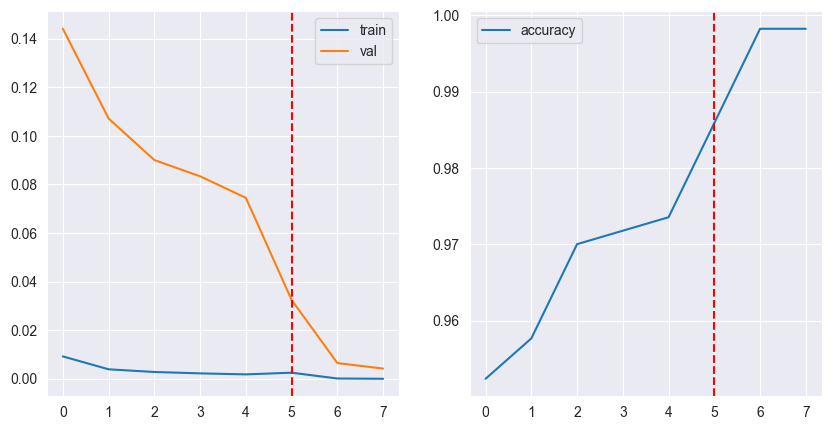

In [28]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.axvline(x=5, color='r', linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='accuracy')
plt.axvline(x=5, color='r', linestyle='--')
plt.legend()

plt.show()

# IV. Проверка качества модели

Для проверки качества модели я воспользуюсь метриками качества классификации: accuracy, precision, recall и f1-score. Также я построю матрицу неточностей, чтобы увидеть, какие классы модель путает между собой. Тестировать модель я буду на датасете, который не использовался ни при обучении, ни при валидации.

In [29]:
preds, targets = evaluation(vit_16, loaders['test'])

accuracy = accuracy_score(targets, preds)
precision = precision_score(targets, preds)
recall = recall_score(targets, preds)
f1 = f1_score(targets, preds)

df_metrics = pd.DataFrame({
    'accuracy': [accuracy],
    'precision': [precision],
    'recall': [recall],
    'f1': [f1]
})

df_metrics

,accuracy,precision,recall,f1
0,0.995074,1.0,0.985507,0.992701


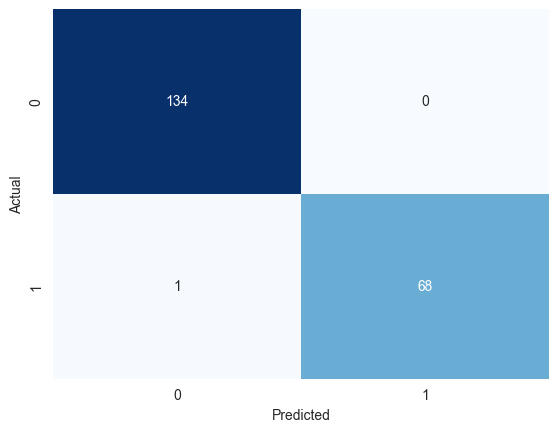

In [30]:
cm = confusion_matrix(targets, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Основываясь на метриках качества, можно сделать вывод, что модель показывает отличные результаты. Важно отметить, что данные показатели были получены на наборе данных, который модель вообще не видела ни при обучении, ни при валидации. Следовательно, речи о переобучении здесь быть не может, так как модель отлично обобщается на незнакомых изображениях.
Если говорить о том, что важнее для данной задачи: точность (precision) или полнота (recall), то, скорее всего, важнее полнота, так как не способность модели определить сгенерированное изображение более важная проблема, чем ошибочное определение реального изображения как сгенерированного. Метрика f1 имеет значение очень близкое к 1, так что модель прекрасно справляется с задачей классификации.

# V. Предсказание на тестовом датасете

In [31]:
target = []

all_test_images = test.id.values.tolist()
print(len(all_test_images))
for image in all_test_images:
    target.append(test_pred(image, vit_16))

submission = pd.DataFrame({'id': all_test_images, 'target': target})
submission.to_csv('submission.csv', index=False)

all_test_images = pd.read_csv('test.csv').id.tolist()
submission = pd.DataFrame({'id': all_test_images, 'target': target})
submission.to_csv('submission.csv', index=False)

print('Предсказания выгружены в файл submission.csv')

506
Предсказания выгружены в файл submission.csv


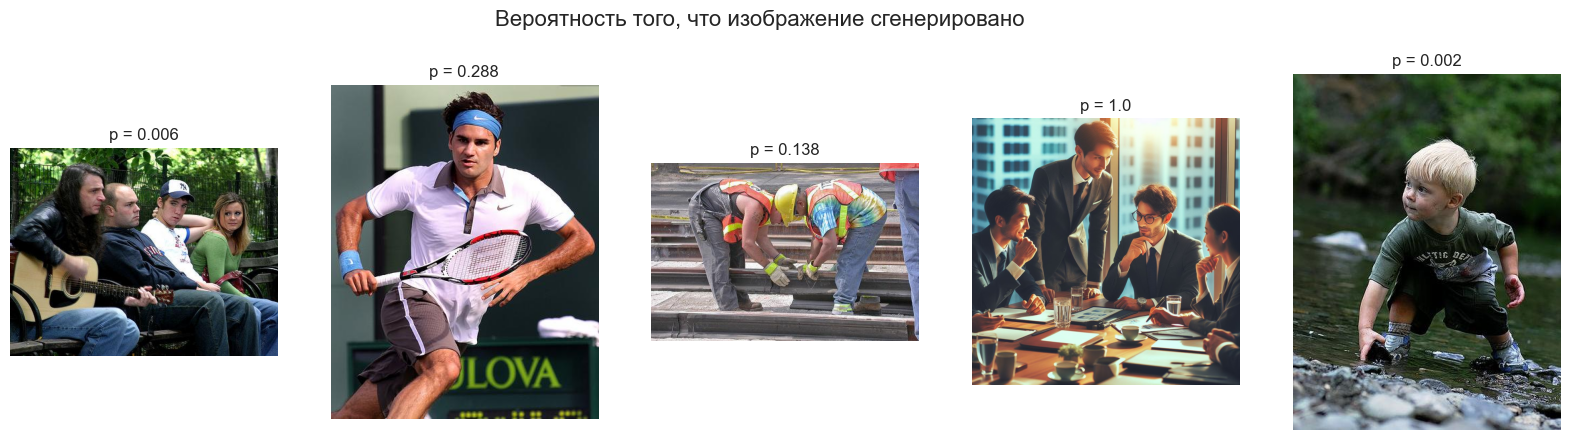

In [32]:
plt.figure(figsize=(20, 5))
plt.suptitle('Вероятность того, что изображение сгенерировано', fontsize=16)
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = Image.open(f'./images/{submission.id[i]}').convert('RGB')
    plt.imshow(img)
    plt.title(f'p = {submission.target[i]}')
    plt.axis('off')